In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
# for avoiding warnings
import warnings
warnings.filterwarnings('ignore')

## The Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 17 fields.

In [2]:
data = pd.read_csv('data/bank.csv',  sep=';',header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(4521, 17)
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


In [3]:
data.head()

age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no

#### Input variables

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric)

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

#### Predict variable (desired target):

y - has the client subscribed a term deposit? (binary: '1','0')

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [4]:
data['education'].unique()

array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object)

educations are "tertiary", "secondary" and "unknown"

### Data exploration

In [5]:
data['y'].value_counts()

no     4000
yes     521
Name: y, dtype: int64

In [6]:
sns.countplot(x='y',data=data, palette='hls')
plt.show()

In [7]:
count_no_sub = len(data[data['y']=="no"])
count_sub = len(data[data['y']=="yes"])
print(count_no_sub+count_sub)
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)

pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

4521
percentage of no subscription is 88.47600088476001
percentage of subscription 11.523999115239992


Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 89:11. Before we go ahead to balance the classes, Let's do some more exploration.

In [8]:
data.groupby('y').mean()

age      balance        day    duration  campaign      pdays  \
y                                                                         
no   40.998000  1403.211750  15.948750  226.347500  2.862250  36.006000   
yes  42.491363  1571.955854  15.658349  552.742802  2.266795  68.639155   

     previous  
y              
no   0.471250  
yes  1.090211

Observations:

The average age of customers who bought the term deposit is higher than that of the customers who didn't. The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale. Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [9]:
data.groupby('job').mean()

age      balance        day    duration  campaign  \
job                                                                      
admin.         39.682008  1226.736402  16.324268  234.669456  2.631799   
blue-collar    40.156448  1085.161734  15.482030  278.161734  2.846723   
entrepreneur   42.011905  1645.125000  15.255952  285.476190  2.589286   
housemaid      47.339286  2083.803571  15.294643  292.633929  2.500000   
management     40.540764  1766.928793  16.254902  260.536636  2.973168   
retired        61.869565  2319.191304  15.556522  285.656522  2.465217   
self-employed  41.453552  1392.409836  16.180328  264.125683  3.278689   
services       38.570743  1103.956835  15.515588  262.486811  2.822542   
student        26.821429  1543.821429  16.392857  248.690476  2.392857   
technician     39.470052  1330.996094  16.183594  252.178385  2.731771   
unemployed     40.906250  1089.421875  16.093750  301.265625  2.679688   
unknown        48.105263  1501.710526  15.842105  216.921053  2.552632   

                   pdays  previous  
job                                 
admin.         49.993724  0.644351  
blue-collar    41.590909  0.493658  
entrepreneur   32.273810  0.428571  
housemaid      26.401786  0.357143  
management     40.968008  0.549020  
retired        35.073913  0.591304  
self-employed  28.256831  0.590164  
services       36.371703  0.443645  
student        45.714286  0.964286  
technician     39.265625  0.576823  
unemployed     36.625000  0.484375  
unknown        36.236842  0.500000

In [10]:
data.groupby('marital').mean()

age      balance        day    duration  campaign      pdays  \
marital                                                                        
divorced  45.475379  1122.390152  15.753788  279.232955  2.604167  38.827652   
married   43.454415  1463.195567  15.905971  256.528781  2.847336  38.466929   
single    33.927258  1460.414716  16.008361  274.601171  2.751672  43.220736   

          previous  
marital             
divorced  0.439394  
married   0.519128  
single    0.642977

In [11]:
data.groupby('education').mean()

age      balance        day    duration  campaign      pdays  \
education                                                                       
primary    46.833333  1411.544248  15.505900  261.709440  2.865782  35.069322   
secondary  40.062446  1196.814397  15.977884  269.863833  2.734172  40.934085   
tertiary   39.645926  1775.423704  16.009630  256.881481  2.901481  39.824444   
unknown    45.299465  1701.245989  15.946524  250.449198  2.486631  41.983957   

           previous  
education            
primary    0.460177  
secondary  0.528621  
tertiary   0.612593  
unknown    0.508021

Visualizations

In [12]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

Text(0, 0.5, 'Frequency of Purchase')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

Text(0, 0.5, 'Proportion of Customers')

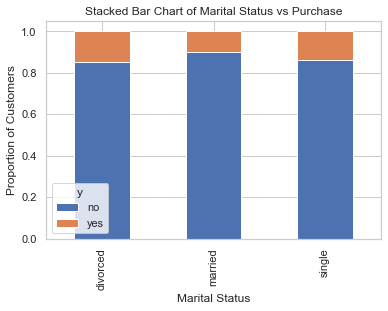

In [13]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

Hard to see, but the marital status does not seem a strong predictor for the outcome variable.

In [14]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

Education seems a good predictor of the outcome variable.

Day of week may not be a good predictor of the outcome.

Text(0, 0.5, 'Frequency of Purchase')

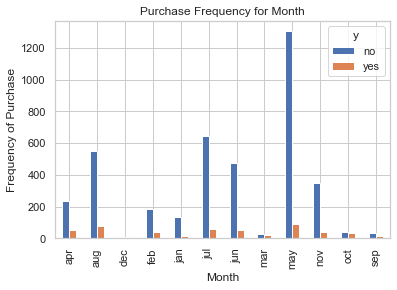

In [15]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')

Month might be a good predictor of the outcome variable.

Text(0, 0.5, 'Frequency')

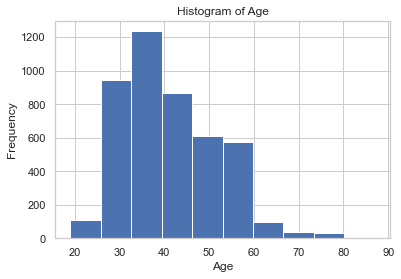

In [16]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

Most customers of the bank in this dataset are in the age range of 30-40.

Text(0, 0.5, 'Frequency of Purchase')

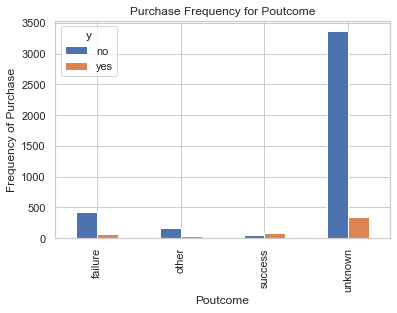

In [17]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')

Poutcome seems to be a good predictor of the outcome variable.

### Create dummy variables

In [18]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    #print(cat_list)
    data1=pd.merge(data, cat_list, left_index=True, right_index=True)
    data=data1
    
cat_vars=['job','marital','education','default','housing','loan','contact','month','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data[to_keep]
data_final.columns.values

array(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

#### Split The data  into Train-Test

In [19]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y'].replace({'yes': 1, 'no': 0})

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Over-sampling using SMOTE

In [21]:
# before Oversampling
sns.countplot(x='y',data=y_train, palette='hls')
plt.show()

In [22]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))

length of oversampled data is  5620


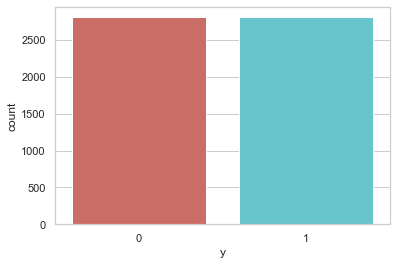

In [23]:
sns.countplot(x='y',data=os_data_y, palette='hls')
plt.show()

### Recursive feature elimination

In [24]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

In [25]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False  True  True  True False False
 False False  True False  True False False  True  True  True  True  True
  True  True False False  True  True False False  True  True  True False
 False False False False False False False False False False False  True
  True False  True]
[28 32 29 30 25 31 27  1  1  1  2  5  7  4  1  6  1  3  8  1  1  1  1  1
  1  1 23 26  1  1 10  9  1  1  1 18 12 20 17 11 13 16 22 15 14 21 19  1
  1 24  1]


The Recursive Feature Elimination (RFE) has helped us select the following features: "previous", "euribor3m", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_fri", "day_of_week_wed", "poutcome_failure", "poutcome_nonexistent", "poutcome_success".

In [26]:
cols=[ 'job_blue-collar', 'job_housemaid', 'default_no', 
      'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

### Implementing the model

In [27]:
import statsmodels.api as sm
logit_model=sm.Logit(y.astype(float),X.astype(float))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.396913
         Iterations 7
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.427    
Dependent Variable:   y                AIC:              4493.2976
Date:                 2020-10-30 22:46 BIC:              4599.4430
No. Observations:     5620             Log-Likelihood:   -2230.6  
Df Model:             15               LL-Null:          -3895.5  
Df Residuals:         5604             LLR p-value:      0.0000   
Converged:            1.0000           Scale:            1.0000   
No. Iterations:       7.0000                                      
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
job_blue-collar   -1.4374   0.1442  -9.9668 0.0000 -1.7200 -1.1547
job_housemaid     -1.4441   0.4359  -3.3126 0.0009 -2

The p-values for four variables are very high, therefore, we will remove them.

In [28]:
cols=['job_blue-collar', 'job_housemaid', 
      'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

In [29]:
logit_model=sm.Logit(y.astype(float),X.astype(float))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.546596
         Iterations 6
                         Results: Logit
Model:               Logit            Pseudo R-squared: 0.211    
Dependent Variable:  y                AIC:              6169.7351
Date:                2020-10-30 22:46 BIC:              6255.9782
No. Observations:    5620             Log-Likelihood:   -3071.9  
Df Model:            12               LL-Null:          -3895.5  
Df Residuals:        5607             LLR p-value:      0.0000   
Converged:           1.0000           Scale:            1.0000   
No. Iterations:      6.0000                                      
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
job_blue-collar  -1.0214   0.1320  -7.7395 0.0000 -1.2801 -0.7627
job_housemaid    -1.1063   0.3935  -2.8116 0.0049 -1.8775 -0.3351


### Logistic Regression Model Fitting

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [31]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.84


### Confusion Matrix

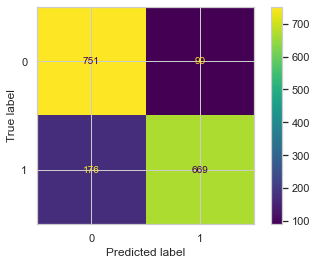

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(logreg, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       841
           1       0.88      0.79      0.83       845

    accuracy                           0.84      1686
   macro avg       0.85      0.84      0.84      1686
weighted avg       0.85      0.84      0.84      1686



#### Interpretation:

Of the entire test set, 74% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 74% of the customer's preferred term deposit were promoted.

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()